## 1. Импорт библиотек

Импортируем стандартные библиотеки для анализа данных, а также пользовательские функции для визуализации и первичного осмотра данных.

In [35]:
import os

import pandas as pd
import numpy as np

from scipy.stats import pearsonr, spearmanr

from utils.overview import describe_categorical
from utils.vizualization import plot_hist_boxplot, plot_categorial_pie, plot_topn_bar, plot_scatterplot
from utils.correlation import get_eta_correlation

## 2. Установка рабочей директории

Определяем корневую директорию проекта для корректного чтения файлов.

In [36]:
HOME = os.getcwd().removesuffix("/notebooks")

## 3. Загрузка очищенных данных

Загружаем файлы cleaned_rides.csv и cleaned_weather.csv нормализованные после очитски.

In [37]:
# Настраиваем словари с параметрами чтения CSV: путь, кодировка, дата-колонки
rides_options = {
    "filepath_or_buffer": f"{HOME}/data/cleaned_rides.csv",
    "encoding": "utf-8",
    "parse_dates": ["start_date", "end_date", "day_timestamp", "hour_timestamp"],
}

weather_options = {
    "filepath_or_buffer": f"{HOME}/data/cleaned_weather.csv",
    "encoding": "utf-8",
    "parse_dates": ["datetime"]
}

rides_weather_options = {
    "filepath_or_buffer": f"{HOME}/data/rides_weather_data.csv",
    "encoding": "utf-8",
    "parse_dates": ["datetime", "start_date", "end_date", "day_timestamp", "hour_timestamp"]
}

rides_data = pd.read_csv(**rides_options)
weather_data = pd.read_csv(**weather_options)
rides_weather_data = pd.read_csv(**rides_weather_options)

## 4. Обзор данных о поездках

После загрузки очищенного датасета выполняется осмотр структуры таблицы, типов данных и распределений основных признаков.


С помощью .head() и .info() проверяем корректность типов столбцов, отсутствие ошибок при чтении дат и соответствие структуры ожидаемому формату. Метод .shape используем для вывода количества оставшихся строк и столбцов после предварительной обработки.

In [38]:
rides_data.head()

,id,start_date,end_date,day_of_week,start_location,start_district,end_location,end_district,distance,promo,duration_minutes,total_price,speed_km_per_h,hour_timestamp,day_timestamp,day_of_week_type
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,суббота,шевченко,юго-восточный,майская,октябрьский,4069.0,Нет,24.0,126.0,10.172500,2023-04-22 09:00:00,2023-04-22,выходной
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,суббота,чехова,заречный,спортивная,октябрьский,4515.0,Нет,28.0,142.0,9.675000,2023-04-22 09:00:00,2023-04-22,выходной
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,суббота,буденного,октябрьский,суворова,ленинский,4520.0,Нет,38.0,182.0,7.136842,2023-04-22 09:00:00,2023-04-22,выходной
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,суббота,труда,центральный,рабочая,северо-западный,3881.0,Нет,32.0,158.0,7.276875,2023-04-22 09:00:00,2023-04-22,выходной
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,суббота,первомайская,северо-западный,юбилейная,юго-восточный,4029.0,Нет,31.0,154.0,7.798065,2023-04-22 09:00:00,2023-04-22,выходной


In [39]:
rides_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93286 entries, 0 to 93285
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                93286 non-null  int64         
 1   start_date        93286 non-null  datetime64[ns]
 2   end_date          93286 non-null  datetime64[ns]
 3   day_of_week       93286 non-null  object        
 4   start_location    93286 non-null  object        
 5   start_district    93286 non-null  object        
 6   end_location      93286 non-null  object        
 7   end_district      93286 non-null  object        
 8   distance          93286 non-null  float64       
 9   promo             93286 non-null  object        
 10  duration_minutes  93286 non-null  float64       
 11  total_price       93286 non-null  float64       
 12  speed_km_per_h    93286 non-null  float64       
 13  hour_timestamp    93286 non-null  datetime64[ns]
 14  day_timestamp     9328

In [40]:
rows, cols = rides_data.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  93286
Number of columns:  16


### 4.1. Анализ числовых признаков

Выделяем числовые столбцы (кроме id) и выводим таблицу описательной статистики: средние значения, стандартное отклонение, диапазон.

Дополнительно визуализируем распределения с помощью plot_hist_boxplot, сравнивая их по признаку promo и оценивая наличие скошенности или аномалий.

In [41]:
rides_num = rides_data.select_dtypes(exclude=["object", "datetime"]).columns.tolist()
rides_num.remove("id")

In [42]:
rides_data[rides_num].describe().T

,count,mean,std,min,25%,50%,75%,max
distance,93286.0,3819.690270,1015.132824,519.00000,3115.000000,3734.0000,4436.000000,8548.000000
duration_minutes,93286.0,26.371031,9.954598,3.00000,19.000000,25.0000,31.000000,85.000000
total_price,93286.0,178.542407,65.778950,20.00000,132.000000,168.0000,210.000000,625.000000
speed_km_per_h,93286.0,9.198018,2.069503,2.28973,7.797418,9.1824,10.566289,29.322857


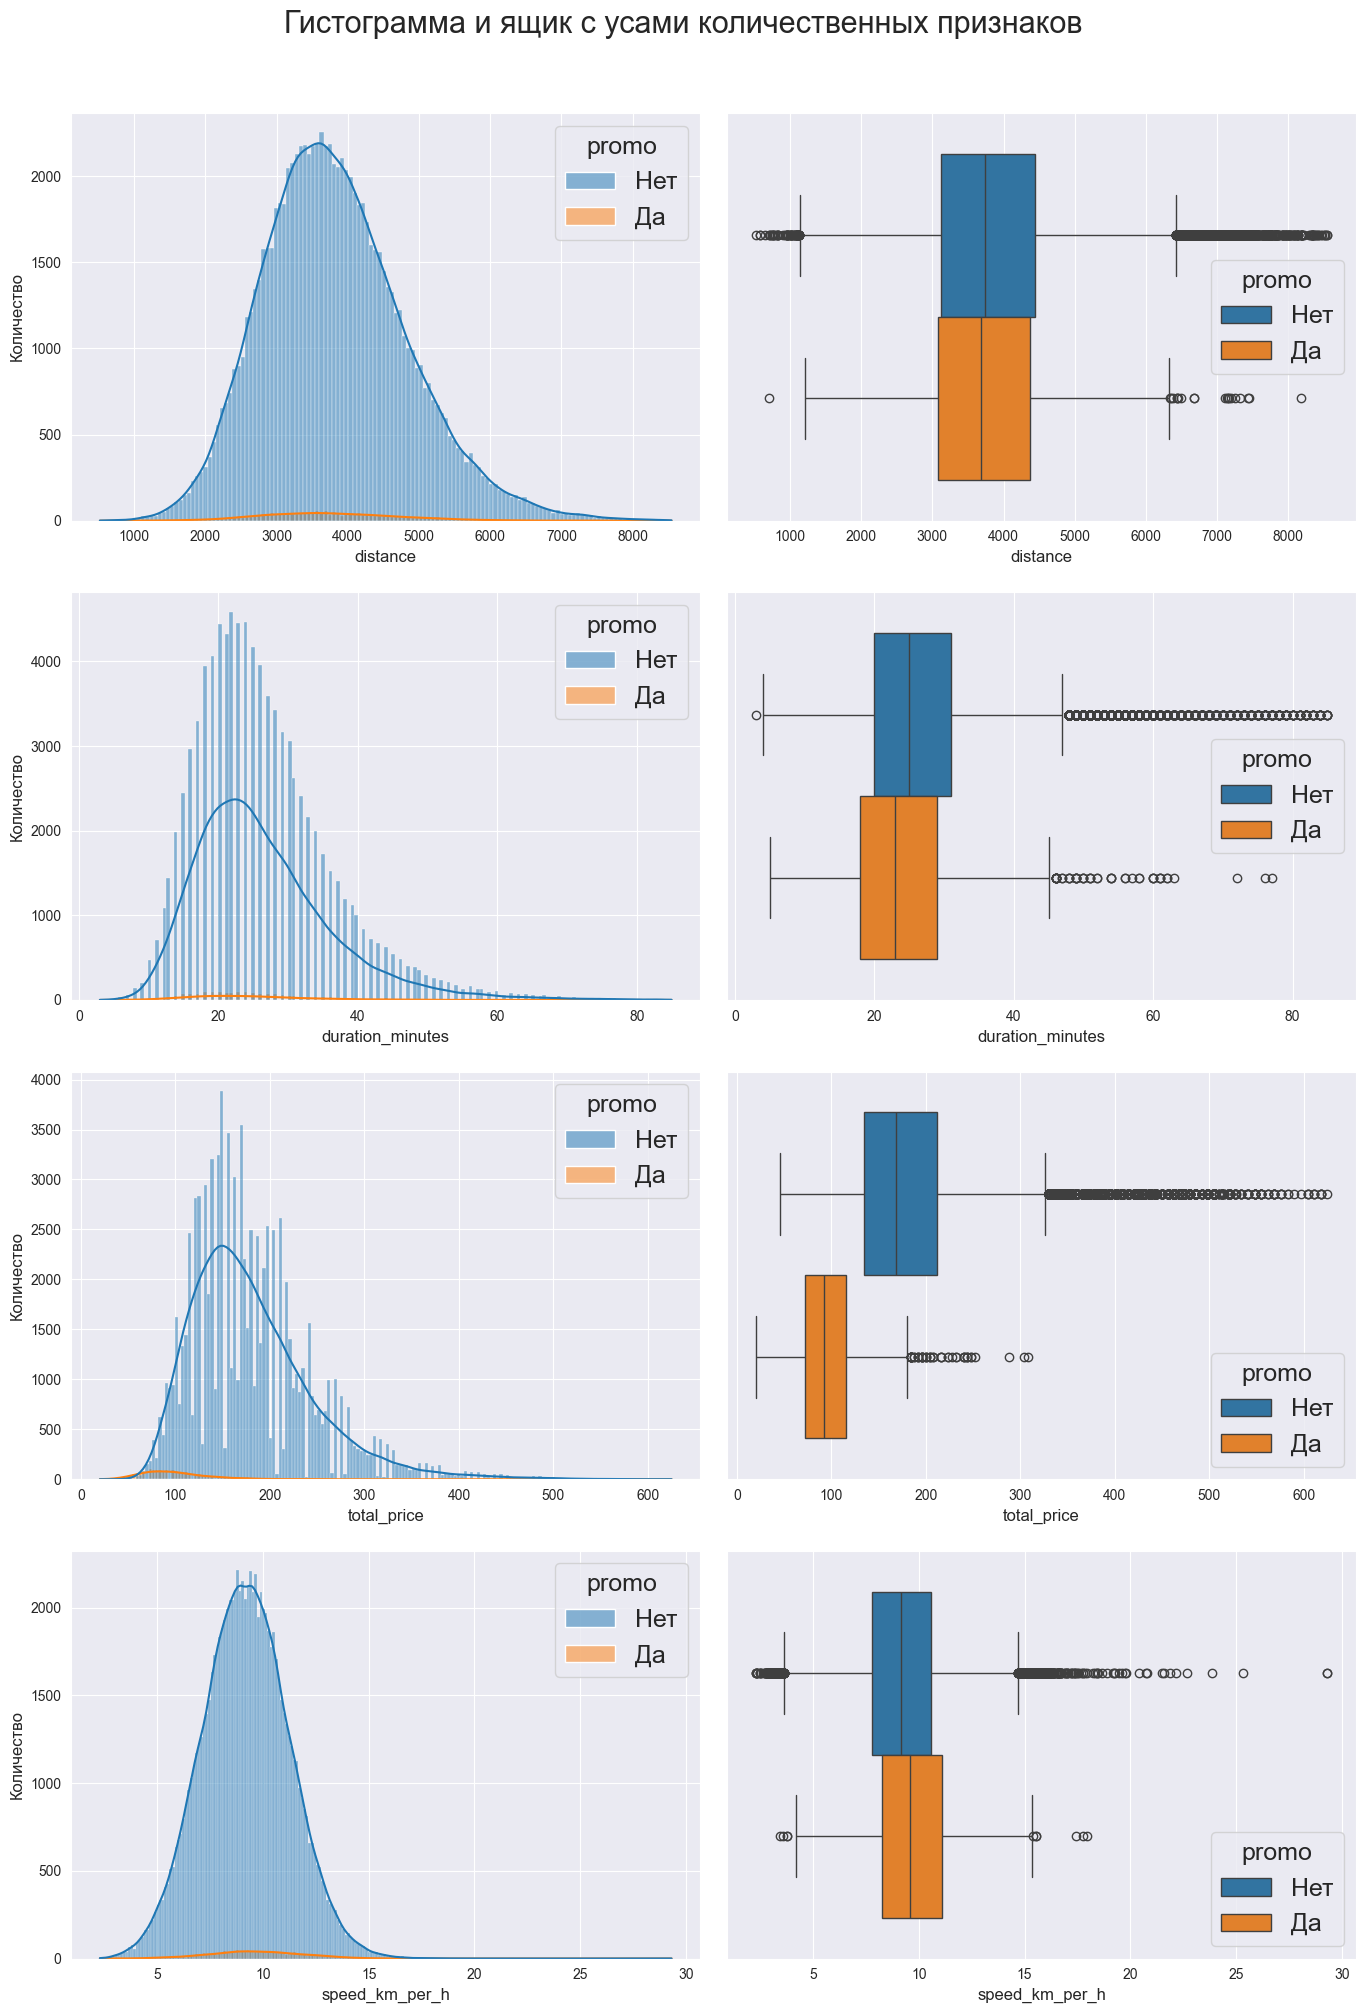

In [43]:
plot_hist_boxplot(rides_data, rides_num, hue="promo", kde=True, save_path=f"{HOME}/hist_boxplot.png")

#### Оценка нормальности распределения для

1) Расстояние (distance)
* Гистограмма: Умеренно симметричная, пик около 3500–4000 км, правый хвост немного длиннее.
* Boxplot: Есть выбросы справа — это типично для расстояний (редкие дальние поездки).
* Вывод: Распределение приближённо нормальное, но с лёгким правым хвостом → можно считать "достаточно нормальным" для практических целей.
2) Продолжительность (duration_minutes)
* Гистограмма: Пик около 20–25 минут, выраженный правый хвост (до 80+ минут).
* Boxplot: Много выбросов справа — это означает, что часть поездок значительно дольше средних.
* Вывод: Явно ненормальное распределение — сильная положительная асимметрия.
3) Общая цена (total_price)
* Гистограмма: Пик около 150–200, очень длинный правый хвост (до 600+).
* Boxplot: Множество выбросов справа — типично для ценовых данных.
* Вывод: Распределение очень сильно скошено вправо — явно не нормальное.
4) Cкорость (speed_km_per_h)
* Гистограмма: Очень симметричное распределение, пик около 9–10 км/ч, хвосты почти одинаковые.
* Boxplot: Небольшие выбросы слева и справа, но основная масса данных плотно сгруппирована.
* Вывод: Распределение приближённо нормальное.

**Итоговый вывод:**

Из всех признаков скорость (speed_km_per_h) и, с небольшими оговорками, расстояние (distance) имеют распределение, близкое к нормальному. Их можно спокойно использовать в моделировании.

А вот duration_minutes и total_price сильно скошены вправо, поэтому их лучше преобразовать перед подачей в модель.

### 4.2. Анализ категориальных признаков

Используем функцию describe_categorical для оценки частот категорий и выводим таблицу описательной статистики.

Строим:
* круговые диаграммы для основных категориальных признаков (день недели, район начала, район окончания);
* бар-чарты для наиболее популярных стартовых и конечных локаций.


In [44]:
describe_categorical(rides_data)

Column: day_of_week
- Unique values: 7
- Top 30 most frequent values:
day_of_week
воскресенье    17394
суббота        17222
пятница        13526
понедельник    12200
среда          11177
четверг        11045
вторник        10722
Name: count, dtype: int64

Column: start_location
- Unique values: 91
- Top 30 most frequent values:
start_location
ломоносова       2202
луговая          2195
майская          2152
буденного        2101
восточная        2094
спортивная       2094
пионерская       1613
шоссейная        1502
комсомольская    1499
садовая          1471
октябрьская      1440
чехова           1421
школьная         1198
чапаева          1183
березовая        1178
строительная     1174
новая            1171
красная          1149
рабочая          1141
некрасова        1135
цветочная        1117
первомайская     1112
московская       1109
лермонтова       1104
суворова         1093
рябиновая        1089
подгорная        1088
колхозная        1087
партизанская     1083
комарова         

In [45]:
rides_cat = rides_data.select_dtypes(include="object").columns

In [46]:
rides_data[rides_cat].describe().T

,count,unique,top,freq
day_of_week,93286,7,воскресенье,17394
start_location,93286,91,ломоносова,2202
start_district,93286,6,центральный,24005
end_location,93286,91,спортивная,2221
end_district,93286,6,центральный,23458
promo,93286,2,Нет,91455
day_of_week_type,93286,2,будний,58670


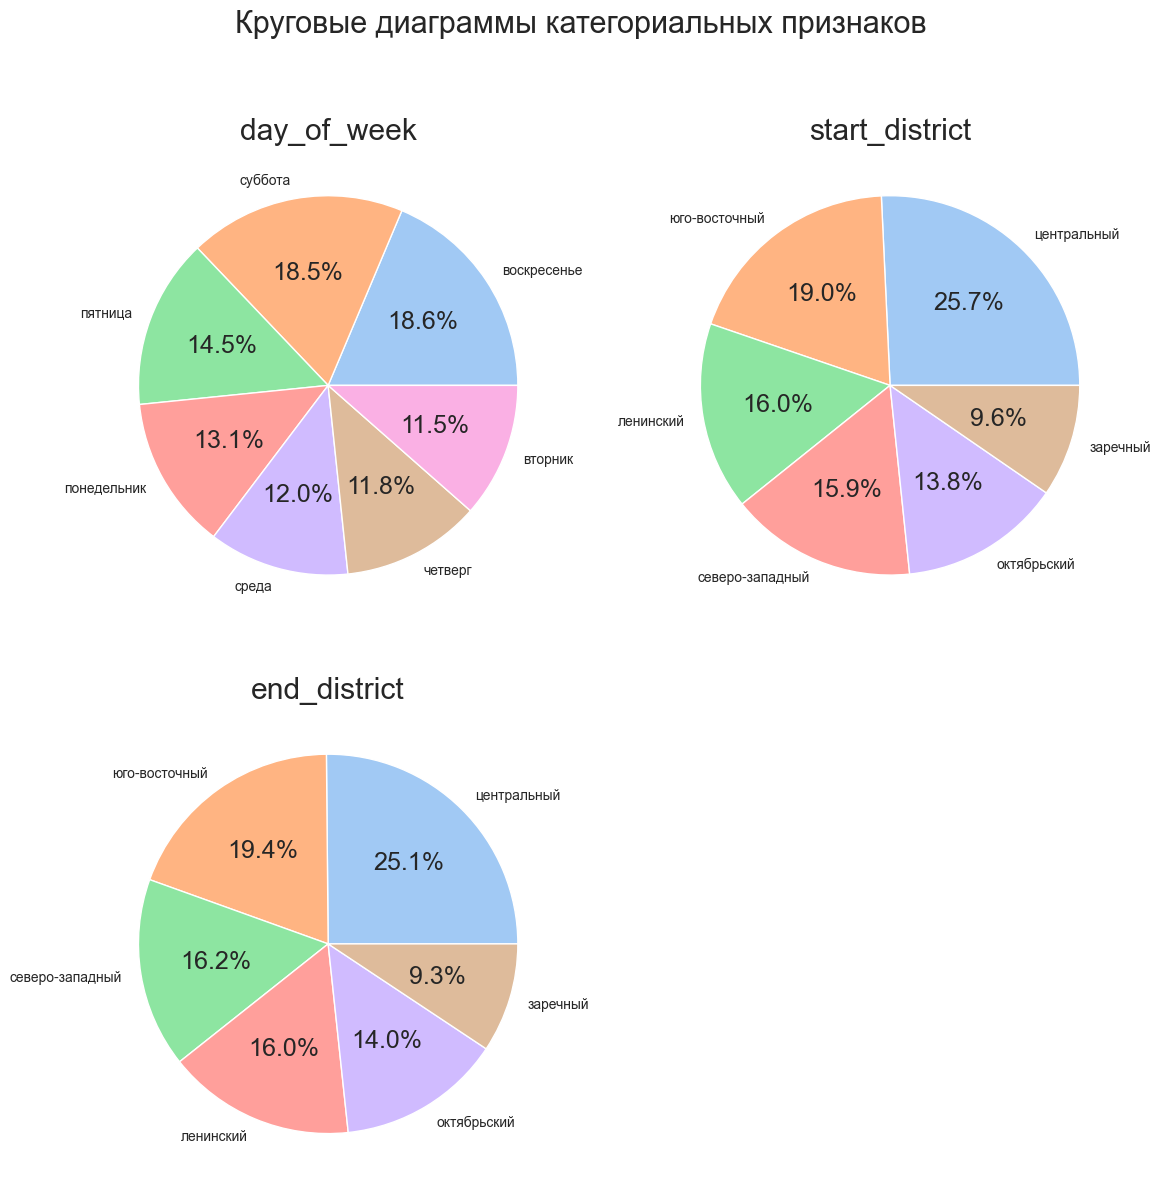

In [47]:
plot_categorial_pie(rides_data, ["day_of_week", "start_district", "end_district"], 2)

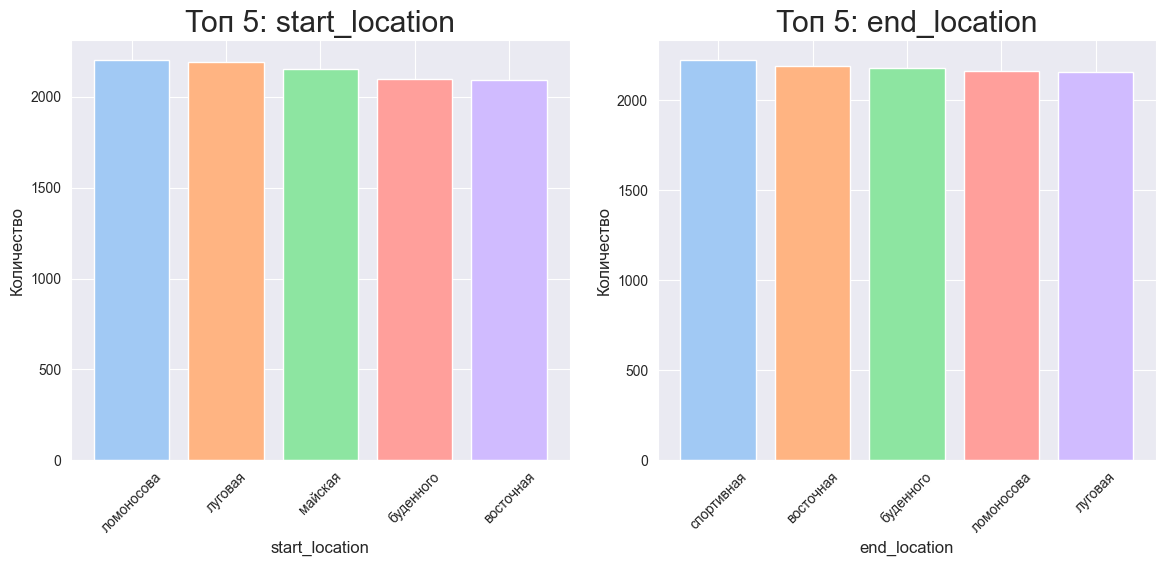

In [48]:
plot_topn_bar(rides_data, ["start_location", "end_location"], n=5)

### 4.3. Корреляция категориальных и числовых признаков

Для проверки взаимосвязи между `day_of_week` с факторами `total_price`, `duration_minutes` и `speed_km_per_h` применяем коэффициент корреляции `eta`.


In [49]:
get_eta_correlation(rides_data["day_of_week"], rides_data["total_price"])

np.float64(0.283)

In [50]:
get_eta_correlation(rides_data["day_of_week"], rides_data["duration_minutes"])

np.float64(0.089)

In [51]:
get_eta_correlation(rides_data["day_of_week"], rides_data["speed_km_per_h"])

np.float64(0.068)

## 5. Исследование спроса в понедельник утром

### 5.1. Фильтрация данных

Выбираем поездки, совершённые:
* в понедельник (day_of_week == "понедельник")
* в утренние часы (с 06:00 до 10:00)

Этот временной интервал важен для оценки commuter-поведения и эффективности утренних промо-кампаний.

In [52]:
monday_morning = rides_data[
    (rides_data['day_of_week'] == 'понедельник') &
    (rides_data["start_date"].dt.hour >= 6) &
    (rides_data["start_date"].dt.hour < 10)
]

### 5.2. Статистика поездок

Считаем:
* количество поездок с/без промо,
* среднюю стоимость,
* суммарную выручку.

Это позволяет увидеть разницу в спросе между акционными и обычными поездками.

In [53]:
count_by_promo = monday_morning.groupby('promo')['id'].count()
avg_price_by_promo = monday_morning.groupby('promo')['total_price'].mean()
total_revenue_by_promo = monday_morning.groupby('promo')['total_price'].sum()

print("Количество поездок в понедельник утром:")
print(count_by_promo)
print("\nВыручка с поездок:")
print(total_revenue_by_promo)
print("\nСредняя стоимость поездки:")
print(avg_price_by_promo)

Количество поездок в понедельник утром:
promo
Да     1831
Нет     734
Name: id, dtype: int64

Выручка с поездок:
promo
Да     180948.0
Нет     95052.0
Name: total_price, dtype: float64

Средняя стоимость поездки:
promo
Да      98.824686
Нет    129.498638
Name: total_price, dtype: float64


### 5.3. Эффективность промо-акции

Считаем:
* долю поездок, совершённых с промокодом,
* выручку от поездок с промо,
* издержки компании (30 ₽ за каждую поездку),
* итоговую окупаемость акции.

Этот блок даёт оценку рентабельности утреннего промо и помогает принимать решения о повторении подобных акций.

In [54]:
# Отбираем поездки с промо в понедельник утром
promo_rides = monday_morning[monday_morning["promo"] == "Да"]

# Конверсия поездок с промо
promo_share = promo_rides.shape[0] / monday_morning.shape[0]
print(f"Конверсия поездок с промо: {promo_share:.1%}\n")

# Выручка и издержки
revenue_promo = promo_rides["total_price"].sum()
promo_cost = promo_rides.shape[0] * 30  # 30 руб. за поездку

print(f"Выручка с промо: {revenue_promo:_.0f} руб.")
print(f"Издержки на акцию: {promo_cost:_.0f} руб.")

# Оценка окупаемости
if revenue_promo > promo_cost:
    print("Акция окупилась")
else:
    print("Акция принесла убытки")

Конверсия поездок с промо: 71.4%

Выручка с промо: 180_948 руб.
Издержки на акцию: 54_930 руб.
Акция окупилась


## 6. Работа с таблицей с почасовым трафиком

### 6.1. Подготовка данных с индексом времени

In [55]:
# Сделаем копии датафрейма для отправлений и прибытия
departures = rides_data[['start_date', 'start_location']].copy()
arrivals = rides_data[['end_date', 'end_location']].copy()

# Индексируем по времени
departures.set_index('start_date', inplace=True)
arrivals.set_index('end_date', inplace=True)

### 6.2. Создаем таблицу с трафиком в каждой точке

In [56]:
# Почасовая агрегация через resample
departures_hourly = departures.groupby('start_location').resample('h', include_groups=False).size().unstack(level=0).fillna(0)
arrivals_hourly = arrivals.groupby('end_location').resample('h', include_groups=False).size().unstack(level=0).fillna(0)

# Переименуем колонки для объединения
departures_hourly.columns.name = 'point'
arrivals_hourly.columns.name = 'point'

# Объединим
traffic_hourly = departures_hourly.add(arrivals_hourly, fill_value=0)

traffic_hourly.head()

point,береговая,березовая,буденного,вишневая,вокзальная,восточная,гагарина,гоголя,горького,дачная,...,чапаева,чехова,чкалова,шевченко,школьная,шоссейная,энергетиков,энтузиастов,юбилейная,южная
2023-04-22 09:00:00,0.0,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
2023-04-22 10:00:00,1.0,1.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,3.0,1.0,0.0,1.0,2.0
2023-04-22 11:00:00,0.0,2.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3.0,1.0,0.0,0.0,1.0
2023-04-22 12:00:00,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,1.0
2023-04-22 13:00:00,1.0,2.0,6.0,1.0,0.0,1.0,2.0,1.0,1.0,0.0,...,1.0,3.0,2.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0


#### Сохраняем таблицу почасового трафика.

In [57]:
traffic_hourly.to_csv(f'{HOME}/data/traffic_hourly.csv')

### 6.3. Топ точек и маршрутов

In [58]:
total_traffic = departures_hourly.sum() + arrivals_hourly.sum()
top_points = total_traffic.sort_values(ascending=False).head(3)

print("Топ-3 точки по общему трафику:")
for i, (point, count) in enumerate(top_points.items(), 1):
    print(f"{i}. {point}: {int(count)} поездок")

Топ-3 точки по общему трафику:
1. ломоносова: 4365 поездок
2. луговая: 4350 поездок
3. спортивная: 4315 поездок


In [59]:
top_routes = rides_data.groupby(['start_location','end_location']).size().sort_values(ascending=False).head(10)

top_routes

start_location  end_location
луговая         спортивная      66
буденного       буденного       65
майская         спортивная      60
спортивная      восточная       57
восточная       луговая         57
ломоносова      спортивная      55
восточная       ломоносова      55
спортивная      майская         55
майская         буденного       54
луговая         луговая         54
dtype: int64

### 6.4. Накопительное поведение (cumsum) для каждой точки

In [60]:
# Разница arrivals - departures
net_flow = arrivals_hourly - departures_hourly

# Накопительный баланс по точке
cumulative_flow = net_flow.cumsum()

#### Сохраняем таблицу накопительного баланса по точке.

In [61]:
cumulative_flow.to_csv(f"{HOME}/data/cumulative_flow.csv")

## 7. Обзор данных о погоде

На этом этапе мы проводим разведочный анализ (EDA) очищенных данных о погоде, чтобы:

- понять распределение числовых признаков,
- оценить их потенциальную применимость в моделях,

In [62]:
weather_data.sample(5)

,datetime,month,hour,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
2751,2023-07-24 15:00:00,7,15,23.010244,0.1,11.966953,14.1,51.454544
2565,2023-07-16 21:00:00,7,21,19.910246,0.0,2.099143,64.0,0.000000
3049,2023-08-06 01:00:00,8,1,16.360247,0.0,13.493999,32.0,0.000000
1612,2023-06-07 04:00:00,6,4,12.700245,0.0,4.349896,1.0,28.707070
2346,2023-07-07 18:00:00,7,18,31.170246,0.0,5.315336,7.5,55.454544


In [63]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   month                3672 non-null   int64         
 2   hour                 3672 non-null   int64         
 3   temperature          3672 non-null   float64       
 4   precipitation_total  3672 non-null   float64       
 5   wind_speed           3672 non-null   float64       
 6   cloud_cover_total    3672 non-null   float64       
 7   sunshine_duration    3672 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 229.6 KB


In [64]:
rows, cols = weather_data.shape
print("Number of rows: ", rows)
print("Number of columns: ", cols)

Number of rows:  3672
Number of columns:  8


### 7.1. Анализ числовых признаков

In [65]:
weather_num = weather_data.select_dtypes(exclude=["object", "datetime"]).columns.tolist()
weather_num.remove("month")
weather_num.remove("hour")

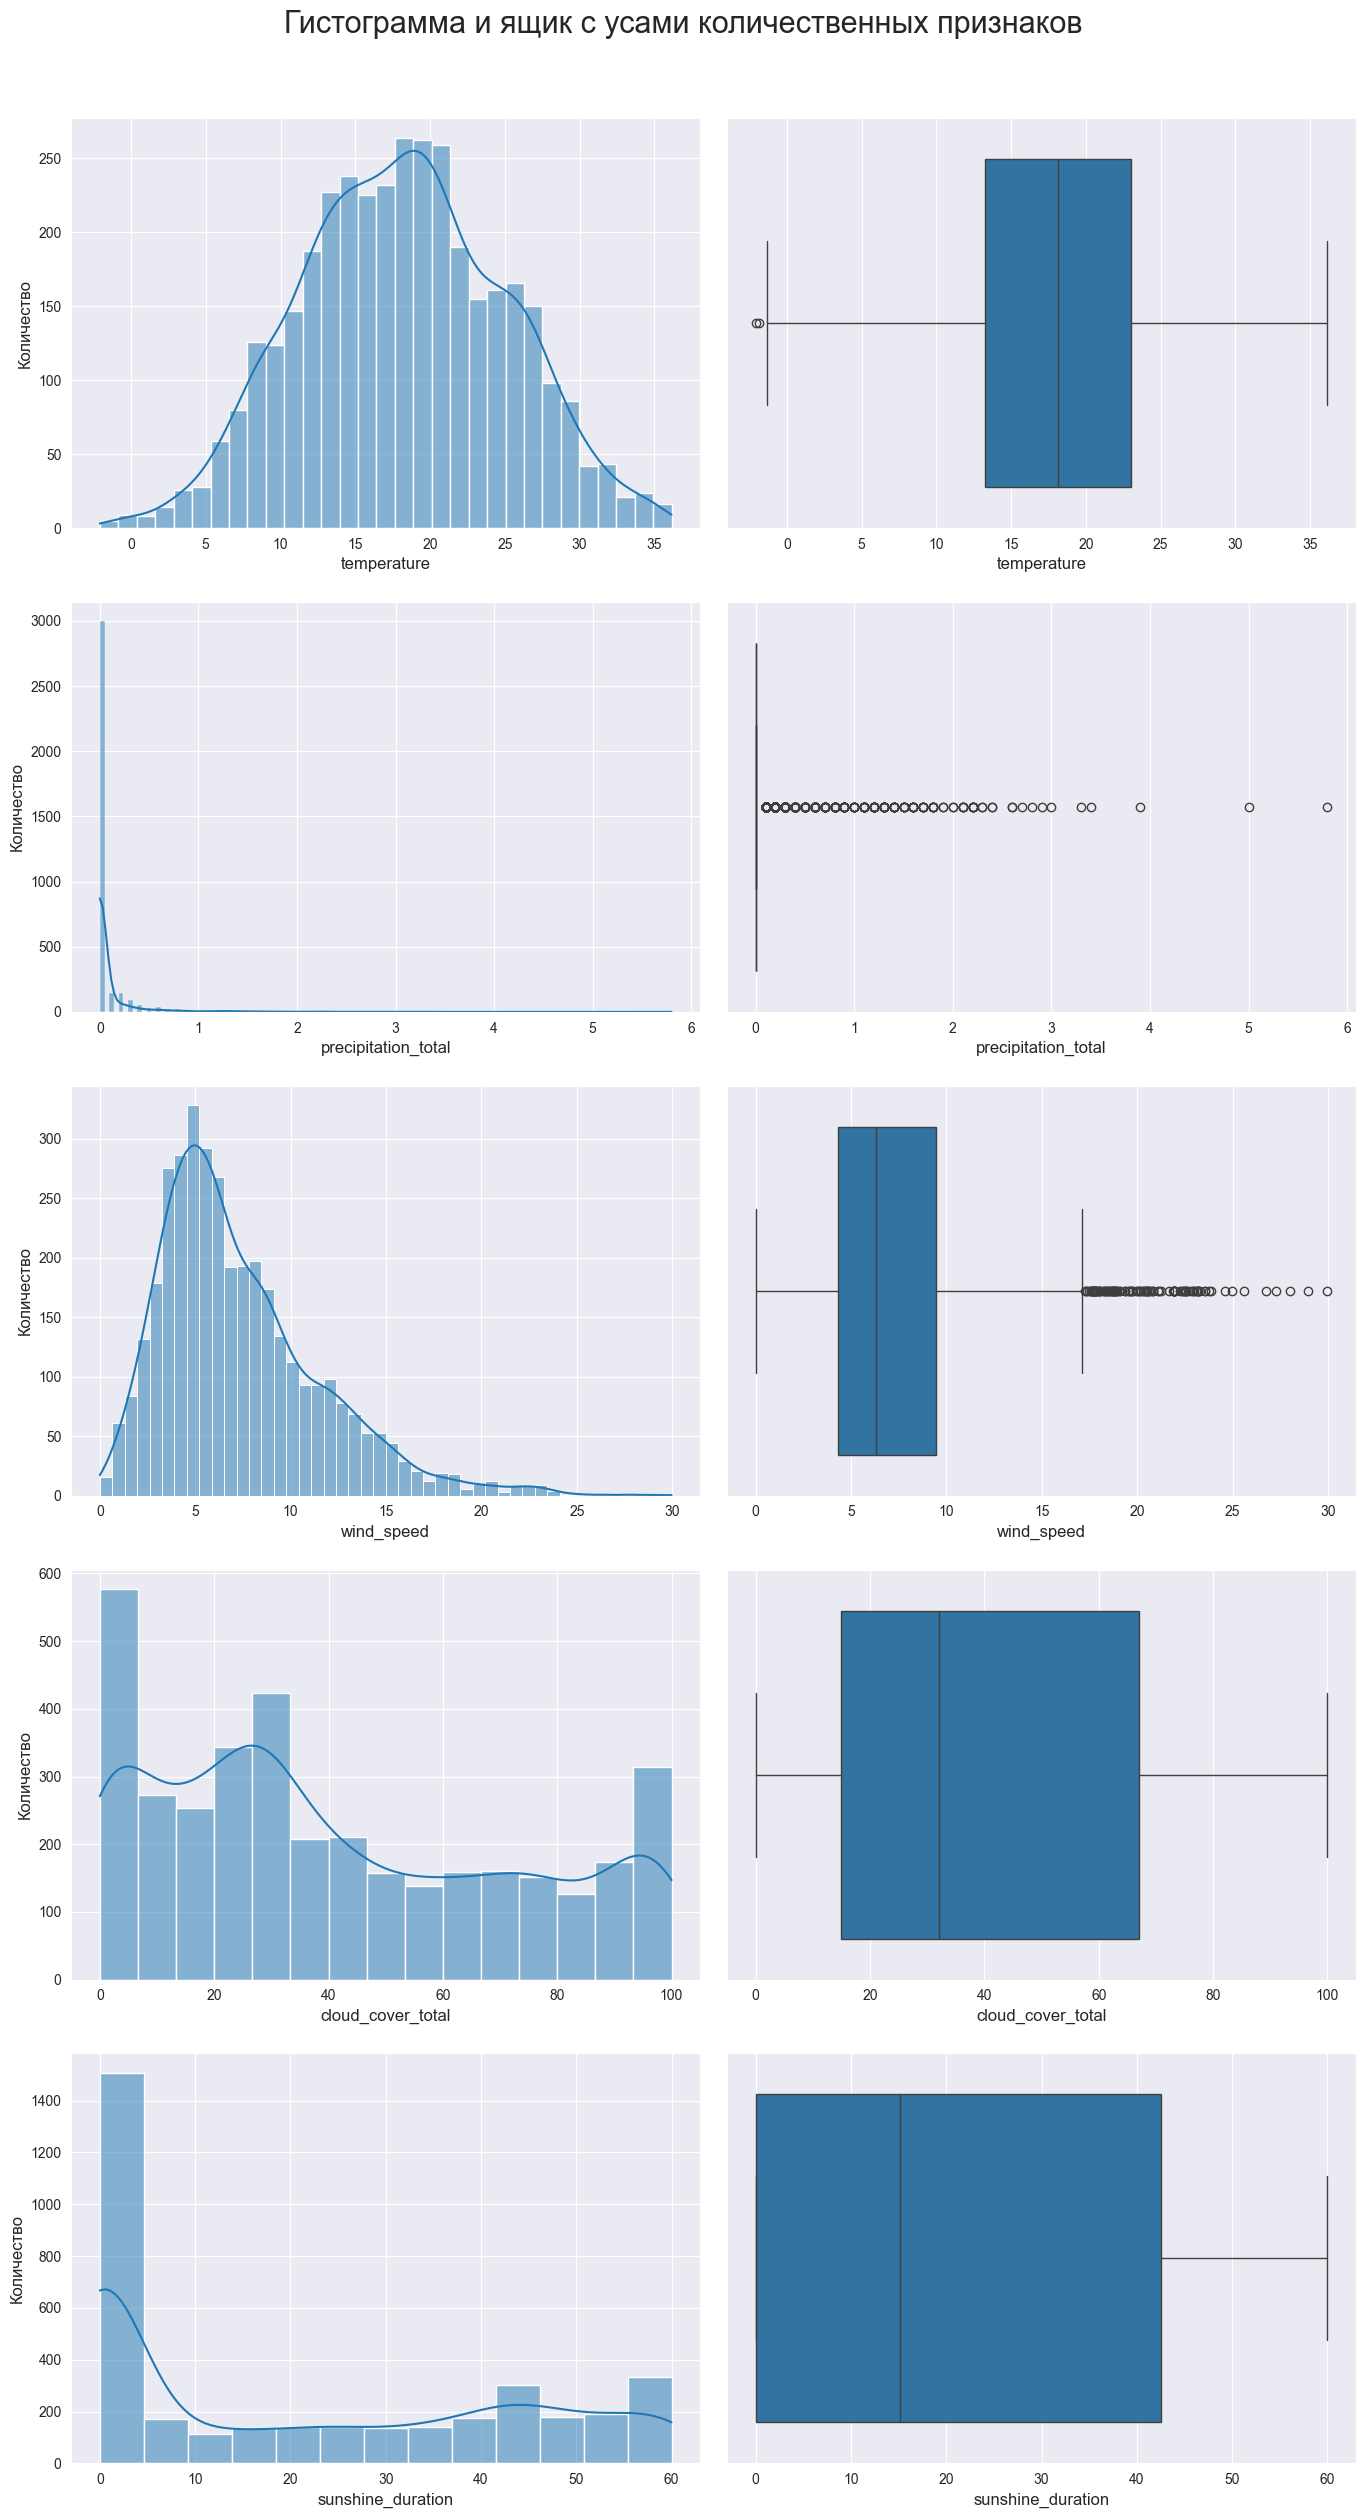

In [66]:
plot_hist_boxplot(weather_data, weather_num, kde=True, save_path=f"{HOME}/hist_boxplot_weather.png")

#### Оценка нормальности распределения для

1) Температура (temperature)
* Гистограмма: Умеренно симметричная, пик около 18–22°C, лёгкий правый и левый хвосты почти сбалансированы.
* Boxplot: Небольшое количество выбросов в обе стороны (низкие зимние и высокие летние температуры), но без сильного перекоса.
* Вывод: Распределение приближённо нормальное, небольшие отклонения объясняются сезонными колебаниями — можно считать «достаточно нормальным» для большинства статистических методов.
2) Общее количество осадков (precipitation_total)
* Гистограмма: Резко выраженный пик при 0 мм, остальные значения быстро убывают — распределение сильно смещено вправо.
* Boxplot: Почти все значения сконцентрированы у нуля, редкие высокие значения выделяются как «выбросы», хотя реальны.
* Вывод: Распределение крайне ненормальное, характерно для данных с частыми нулями.
3) Скорость ветра (wind_speed)
* Гистограмма: Пик около 5–7 м/с, умеренный правый хвост (вплоть до 30 м/с), левый хвост усечён (нет отрицательных значений).
* Boxplot: Выбросы наблюдаются в правой части (сильный ветер), что типично для метеоданных.
* Вывод: Вывод: Распределение умеренно скошено вправо, не является нормальным.
4) Облачность (cloud_cover_total)
* Гистограмма: Мультимодальная — пики на 0%, 20%, 50%, 80% и 100%, характерна для измерений по дискретной шкале.
* Boxplot: Медиана смещена вправо (~60%), но «выбросы» — это просто другие дискретные уровни облачности.
* Вывод: Распределение не подходит под модель нормальности — оно дискретное и категориальное по сути, а не непрерывное.
5) Продолжительность солнечного света (sunshine_duration)
* Гистограмма: Массивный пик при 0 часов (полная облачность), остальные значения редки и сосредоточены в диапазоне 40–60 часов - явно дискретная структура.
* Boxplot: Медиана близка к нулю, множество значений справа выглядят как выбросы, но отражают ясные дни.
* Вывод: Распределение сильно ненормальное и дискретное. Использование как непрерывного признака может ввести модель в заблуждение.

**Итоговый вывод:**

Температура (temperature) имеет распределение, близкое к нормальному, небольшие сезонные отклонения не критичны. Её можно использовать напрямую в моделировании.

Скорость ветра (wind_speed) умеренно скошена вправо, поэтому с ней нужно быть аккуратнее при использовании в моделях, чувствительных к нормальности.

А вот осадки (precipitation_total), облачность (cloud_cover_total) и продолжительность солнечного света (sunshine_duration) сильно ненормальные и/или дискретные, поэтому их лучше преобразовать перед моделированием.